<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_045_imbalanced_data_class_0_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


### Load & Preprocess

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import warnings
from loan_data_utils import load_and_preprocess_data, plot_class_distribution, plot_mean_class_metrics

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])




### Problem of Class Imbalance

**Class imbalance** occurs when one class in a dataset significantly outnumbers the other classes. This is common in many real-world scenarios, such as fraud detection, medical diagnoses, and loan defaults. In such cases, the majority class (the more frequent class) dominates the dataset, while the minority class (the less frequent class) is underrepresented.

### Impact on Model Performance

When training a machine learning model on imbalanced data, the model tends to become biased towards the majority class. This bias can lead to the following issues:

1. **High Accuracy but Poor Minority Class Performance**: The model may achieve high overall accuracy by simply predicting the majority class most of the time. However, it will likely perform poorly on the minority class, failing to identify critical instances.

2. **High Precision and Recall for the Majority Class**: Precision and recall scores for the majority class may be high because the model is good at predicting the majority class correctly. However, this often comes at the expense of poor performance for the minority class.

3. **Low Precision and Recall for the Minority Class**: Precision and recall scores for the minority class are typically low because the model struggles to correctly identify minority class instances. This is problematic in scenarios where identifying the minority class correctly is crucial (e.g., detecting fraudulent transactions or diagnosing diseases).

### Checking for Class Imbalance Issues

To check for the impact of class imbalance on model performance, you can:

1. **Analyze Class Distribution**: Examine the distribution of classes in your dataset. If there is a significant imbalance, it indicates a potential issue.

2. **Evaluate Precision and Recall Scores**: Assess precision and recall scores for both the majority and minority classes. High precision and recall for the majority class and low scores for the minority class suggest that the model is biased towards the majority class.

3. **Confusion Matrix**: A confusion matrix provides a detailed breakdown of true positives, false positives, true negatives, and false negatives for each class. This helps in understanding how well the model performs on each class.

4. **F1 Score**: The F1 score, which is the harmonic mean of precision and recall, can be calculated for both classes. A low F1 score for the minority class indicates poor performance.

### Addressing Class Imbalance

To address class imbalance and improve model performance on the minority class, you can:

1. **Resampling Techniques**: Use techniques like oversampling (e.g., SMOTE) to increase the number of minority class instances, or undersampling to reduce the number of majority class instances.

2. **Class Weight Adjustment**: Adjust class weights in your model to give more importance to the minority class. This helps the model focus on learning to identify minority class instances better.

3. **Ensemble Methods**: Use ensemble methods like bagging and boosting, which can help improve the performance of models on imbalanced data.

4. **Threshold Tuning**: Adjust the decision threshold to balance precision and recall for the minority class.

By implementing these techniques, you can create more balanced models that perform well on both the majority and minority classes, leading to more reliable and accurate predictions.

### Class Distribution Plot

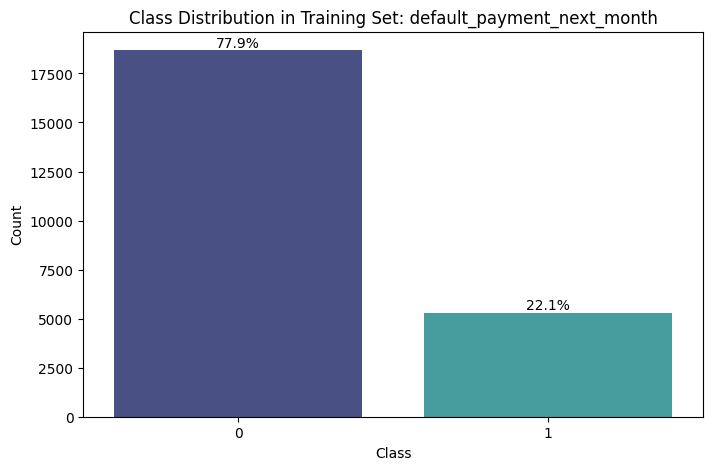

In [7]:
plot_class_distribution(y_train, target)

### Model Performance Plot

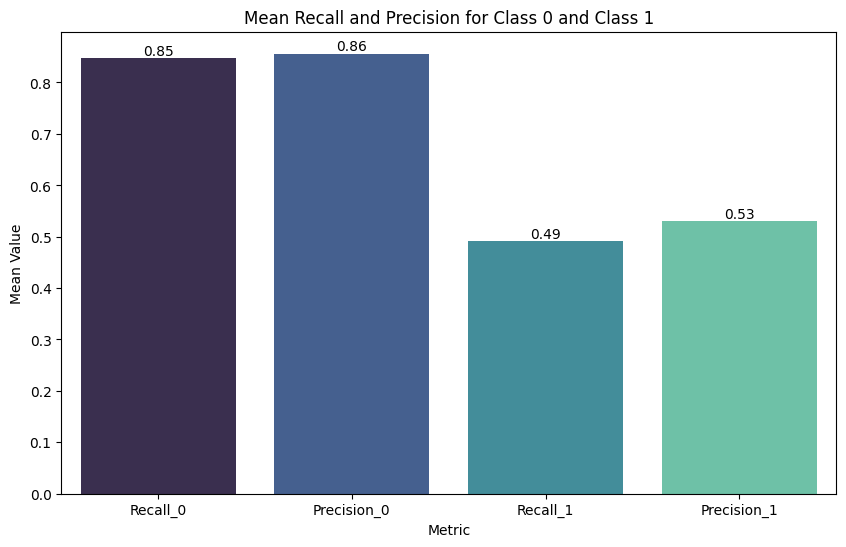

In [13]:
from loan_data_utils import plot_mean_class_metrics
# Load the CSV file into a DataFrame
file_path = '/content/combined_model_metrics_with_resampling.csv'
metrics_df = pd.read_csv(file_path)
plot_mean_class_metrics(metrics_df)

### Top Models

In [14]:
from loan_data_utils import get_top_performers, select_and_sort_top_n

# Load the CSV file into a DataFrame
file_path = '/content/combined_model_metrics_with_resampling.csv'
data = pd.read_csv(file_path)

columns_to_check = ['Precision_0']
# columns_to_check = ['Recall_0', 'Precision_0', 'F1_0', 'Recall_1',
#                     'Precision_1', 'F1_1', 'F1_Macro', 'Accuracy']
top3_combined_df = select_and_sort_top_n(df, columns_to_check, n=3)
top3_combined_df

,Model,Experiment,Recall_0,Precision_0,F1_0,Recall_1,Precision_1,F1_1,F1_Macro,Accuracy
0,LGBM (RandomUnderSampler),resampling,0.770383,0.882786,0.822763,0.639789,0.441727,0.522622,0.672693,0.741500
1,HistGradientBoosting (RandomUnderSampler),resampling,0.786433,0.881929,0.831448,0.629239,0.455537,0.528481,0.679964,0.751667
2,Random Forest (RandomUnderSampler),resampling,0.775947,0.880738,0.825028,0.629992,0.443972,0.520872,0.672950,0.743667


In [17]:
print(top3_combined_df['Model'].values)

['LGBM (RandomUnderSampler)' 'HistGradientBoosting (RandomUnderSampler)'
 'Random Forest (RandomUnderSampler)']


### LGBM (RandomUnderSampler) Tuning

In [32]:
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from loan_data_utils import evaluate_model, clean_params
import json

# Define the hyperparameter grid
param_grid_lgbm = {
    'classifier__num_leaves': [31, 50, 70],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200, 300]
}

# LGBM with RandomUnderSampler
pipeline_lgbm_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler()),
    ('classifier', LGBMClassifier(random_state=42, force_col_wise=True))
])

# Setup GridSearchCV
grid_lgbm_rus = GridSearchCV(pipeline_lgbm_rus, param_grid=param_grid_lgbm, scoring='precision', cv=5)

# Fit the model
grid_lgbm_rus.fit(X_train, y_train)

# Get the best model and its parameters
best_params_lgbm_rus = grid_lgbm_rus.best_params_
print("Best LGBM (RandomUnderSampler) Parameters:", best_params_lgbm_rus)

# Evaluate the best model
evaluation_results_lgbm_rus = evaluate_model(grid_lgbm_rus.best_estimator_, X_train, X_test, y_train, y_test, 'LGBM (RandomUnderSampler)', 'Class 0 Precision')
print("\nLGBM (RandomUnderSampler) - Best Model Evaluation:")
print(evaluation_results_lgbm_rus)

# Clean the parameters
best_params_lgbm_rus_clean = clean_params(best_params_lgbm_rus)

# Load existing parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Create "Class 0 Precision" category if it doesn't exist
if "Class 0 Precision" not in top_model_params:
    top_model_params["Class 0 Precision"] = {}

# Update the top models and parameters with the new tuning results
top_model_params["Class 0 Precision"]["LGBM (RandomUnderSampler)"] = {
    "best_params": best_params_lgbm_rus_clean
}

# Save the updated top model parameters to the JSON file
with open('/content/top_model_params.json', 'w') as f:
    json.dump(top_model_params, f, indent=4)


[LightGBM] [Info] Number of positive: 4248, number of negative: 4248
[LightGBM] [Info] Total Bins 3258
[LightGBM] [Info] Number of data points in the train set: 8496, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4247, number of negative: 4247
[LightGBM] [Info] Total Bins 3255
[LightGBM] [Info] Number of data points in the train set: 8494, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4247, number of negative: 4247
[LightGBM] [Info] Total Bins 3254
[LightGBM] [Info] Number of data points in the train set: 8494, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4247, number of negative: 4247
[LightGBM] [Info] Total Bins 3258
[LightGBM] [Info] Number of data points in the train set: 8494, number of u

#### LGBM (RandomUnderSampler) Tuning Plot

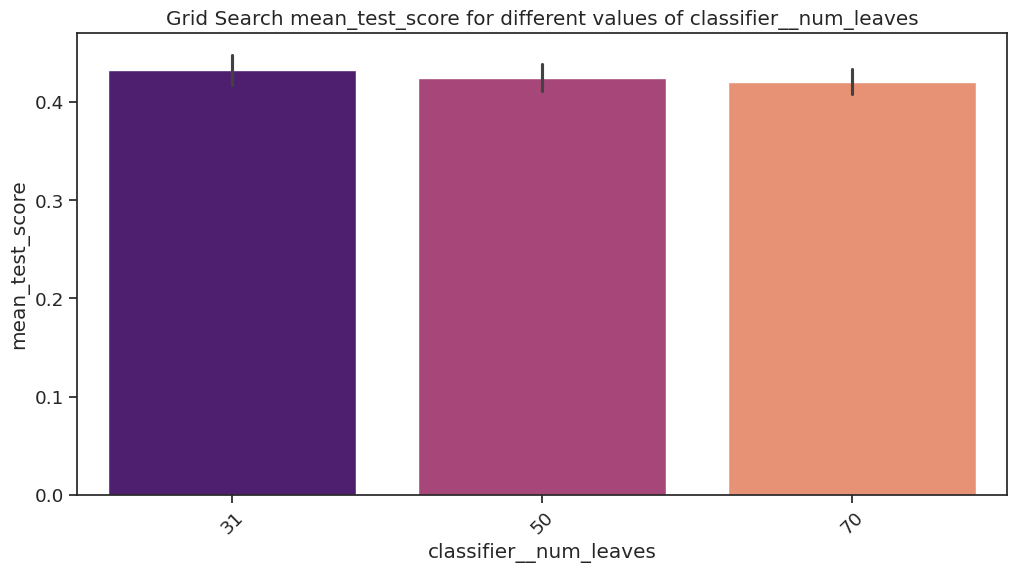

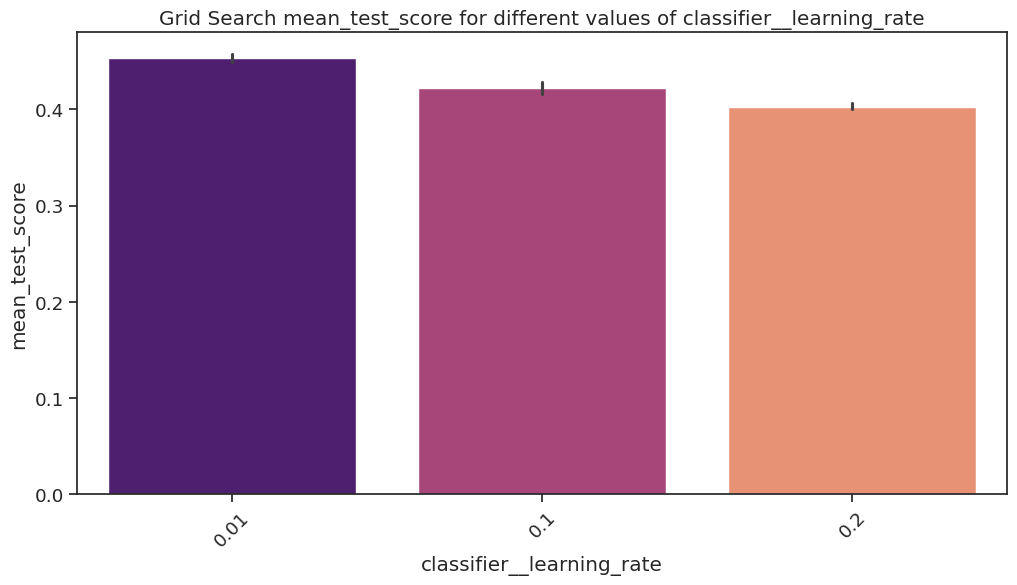

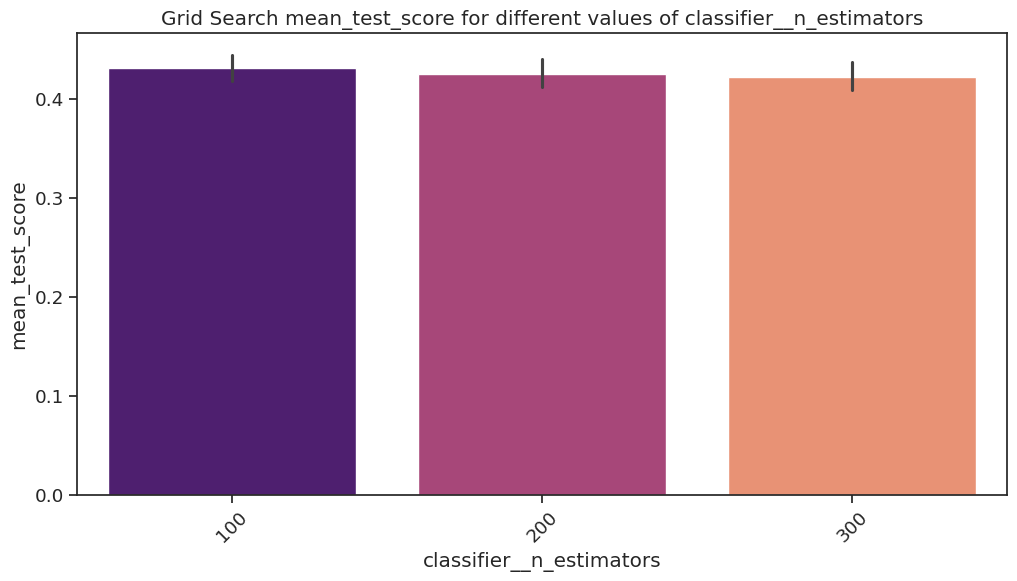

In [21]:
# Extract the results from GridSearchCV
results = grid_lgbm_rus.cv_results_

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Function to plot bar charts of grid search results
def plot_grid_search_results(results_df, param, score='mean_test_score'):
    plt.figure(figsize=(12, 6))
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("ticks")

    # Extract the values of the specified parameter
    param_values = results_df[f'param_{param}'].astype(str)

    # Plot the results
    sns.barplot(x=param_values, y=results_df[score], hue=param_values, palette='magma')

    plt.title(f'Grid Search {score} for different values of {param}')
    plt.xlabel(param)
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Example usage for LGBM parameters
plot_grid_search_results(results_df, 'classifier__num_leaves', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__learning_rate', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__n_estimators', score='mean_test_score')

### HistGradientBoosting (RandomUnderSampler) Tuning

In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Define the hyperparameter grid
param_grid_hgb = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_iter': [100, 200, 300],
    'classifier__max_leaf_nodes': [31, 50, 70]
}

# HistGradientBoosting with RandomUnderSampler
pipeline_hgb_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler()),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

# Setup GridSearchCV
grid_hgb_rus = GridSearchCV(pipeline_hgb_rus, param_grid=param_grid_hgb, scoring='precision', cv=5)

# Fit the model
grid_hgb_rus.fit(X_train, y_train)

# Get the best model and its parameters
best_params_hgb_rus = grid_hgb_rus.best_params_
print("Best HistGradientBoosting (RandomUnderSampler) Parameters:", best_params_hgb_rus)

# Evaluate the best model
evaluation_results_hgb_rus = evaluate_model(grid_hgb_rus.best_estimator_, X_train, X_test, y_train, y_test, 'HistGradientBoosting (RandomUnderSampler)', 'Class 0 Precision')
print("\nHistGradientBoosting (RandomUnderSampler) - Best Model Evaluation:")
print(evaluation_results_hgb_rus)

# Clean the parameters
best_params_hgb_rus_clean = clean_params(best_params_hgb_rus)

# Load existing parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Update the top models and parameters with the new tuning results
top_model_params["Class 0 Precision"]["HistGradientBoosting (RandomUnderSampler)"] = {
    "best_params": best_params_hgb_rus_clean
}

# Save the updated top model parameters to the JSON file
with open('/content/top_model_params.json', 'w') as f:
    json.dump(top_model_params, f, indent=4)


Best HistGradientBoosting (RandomUnderSampler) Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_iter': 100, 'classifier__max_leaf_nodes': 31}

HistGradientBoosting (RandomUnderSampler) - Best Model Evaluation:
{'Model': 'HistGradientBoosting (RandomUnderSampler)', 'Experiment': 'Class 0 Precision', 'Recall_0': 0.7958484913331907, 'Precision_0': 0.8804450757575758, 'F1_0': 0.8360121389232325, 'Recall_1': 0.6194423511680482, 'Precision_1': 0.46283783783783783, 'F1_1': 0.529809861424428, 'F1_Macro': 0.6829110001738302, 'Accuracy': 0.7568333333333334}


#### HistGradientBoosting (RandomUnderSampler) Tuning Plot

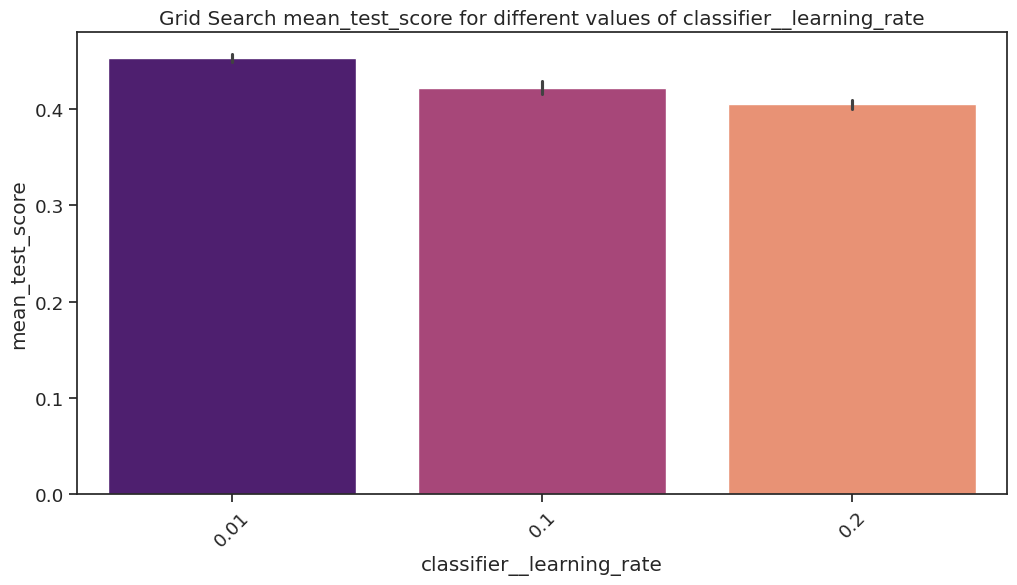

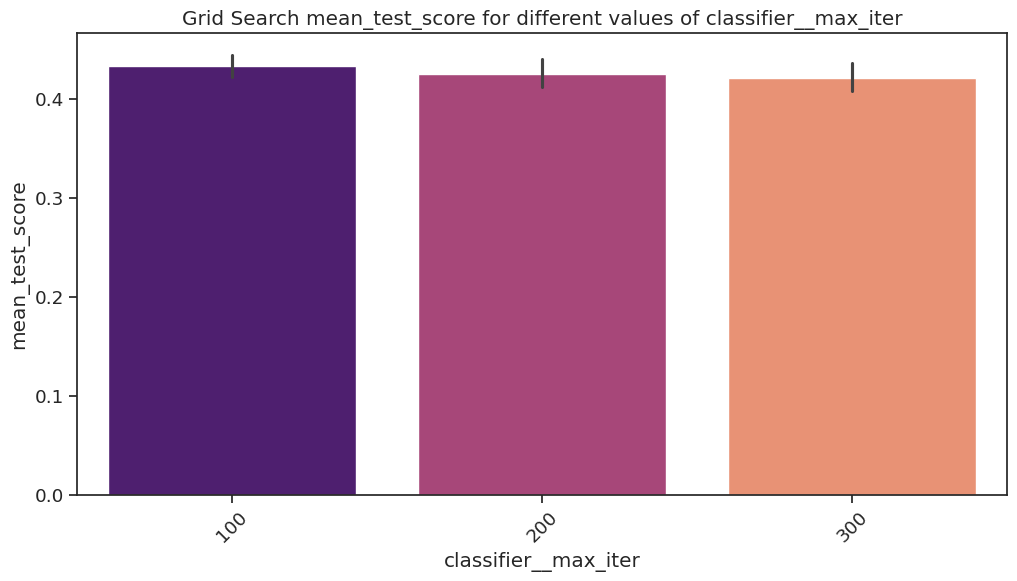

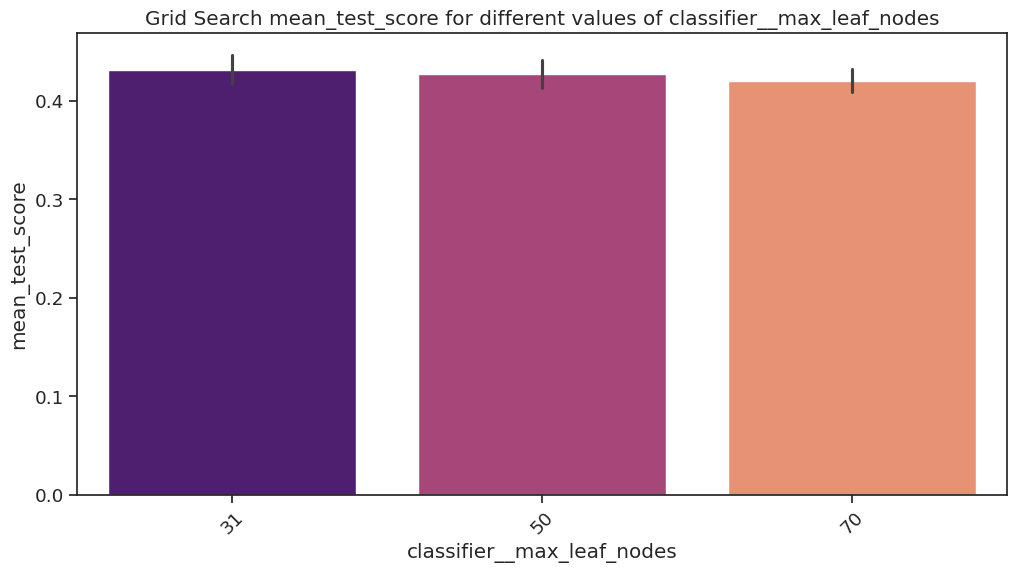

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the results from GridSearchCV
results = grid_hgb_rus.cv_results_

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Function to plot bar charts of grid search results
def plot_grid_search_results(results_df, param, score='mean_test_score'):
    plt.figure(figsize=(12, 6))
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("ticks")

    # Extract the values of the specified parameter
    param_values = results_df[f'param_{param}'].astype(str)

    # Plot the results
    sns.barplot(x=param_values, y=results_df[score], palette='magma')

    plt.title(f'Grid Search {score} for different values of {param}')
    plt.xlabel(param)
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Example usage for HistGradientBoosting parameters
plot_grid_search_results(results_df, 'classifier__learning_rate', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__max_iter', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__max_leaf_nodes', score='mean_test_score')


### Random Forest (RandomUnderSampler) Tuning

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Random Forest with RandomUnderSampler
pipeline_rf_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Setup GridSearchCV
grid_rf_rus = GridSearchCV(pipeline_rf_rus, param_grid=param_grid_rf, scoring='precision', cv=5)

# Fit the model
grid_rf_rus.fit(X_train, y_train)

# Get the best model and its parameters
best_params_rf_rus = grid_rf_rus.best_params_
print("Best Random Forest (RandomUnderSampler) Parameters:", best_params_rf_rus)

# Evaluate the best model
evaluation_results_rf_rus = evaluate_model(grid_rf_rus.best_estimator_, X_train, X_test, y_train, y_test, 'Random Forest (RandomUnderSampler)', 'Class 0 Precision')
print("\nRandom Forest (RandomUnderSampler) - Best Model Evaluation:")
print(evaluation_results_rf_rus)

# Clean the parameters
best_params_rf_rus_clean = clean_params(best_params_rf_rus)

# Load existing parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Update the top models and parameters with the new tuning results
top_model_params["Class 0 Precision"]["Random Forest (RandomUnderSampler)"] = {
    "best_params": best_params_rf_rus_clean
}

# Save the updated top model parameters to the JSON file
with open('/content/top_model_params.json', 'w') as f:
    json.dump(top_model_params, f, indent=4)


Best Random Forest (RandomUnderSampler) Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}

Random Forest (RandomUnderSampler) - Best Model Evaluation:
{'Model': 'Random Forest (RandomUnderSampler)', 'Experiment': 'Class 0 Precision', 'Recall_0': 0.8056922747699551, 'Precision_0': 0.881939564300773, 'F1_0': 0.842093491388951, 'Recall_1': 0.6201959306706858, 'Precision_1': 0.4754477180820335, 'F1_1': 0.5382603008502289, 'F1_Macro': 0.69017689611959, 'Accuracy': 0.7646666666666667}


#### Random Forest (RandomUnderSampler) Tuning Plot

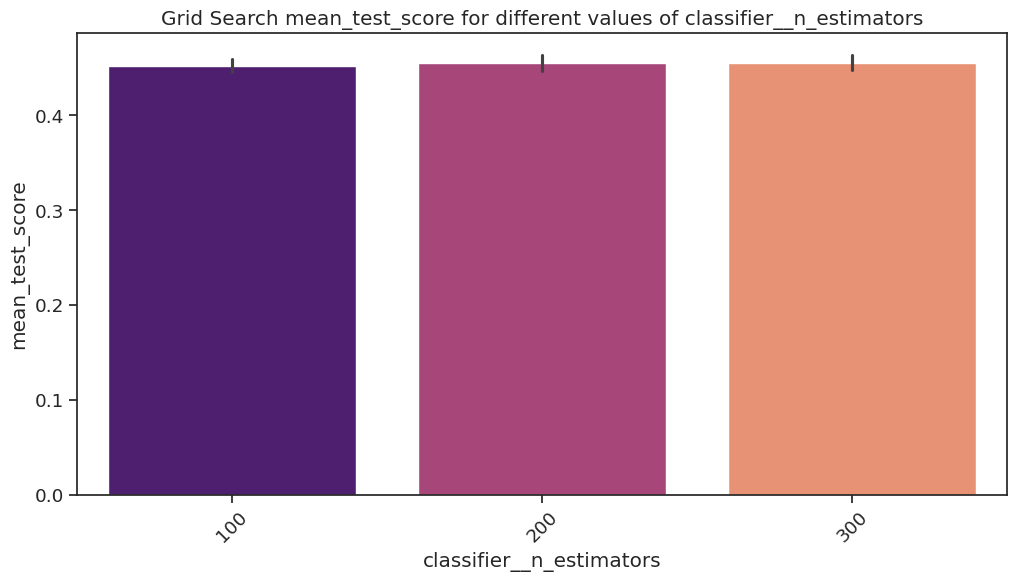

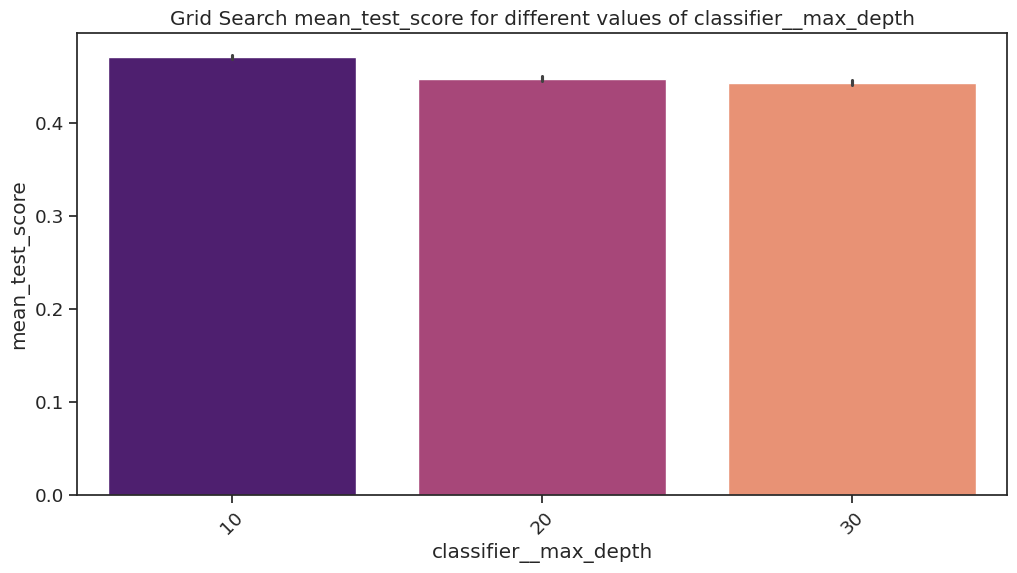

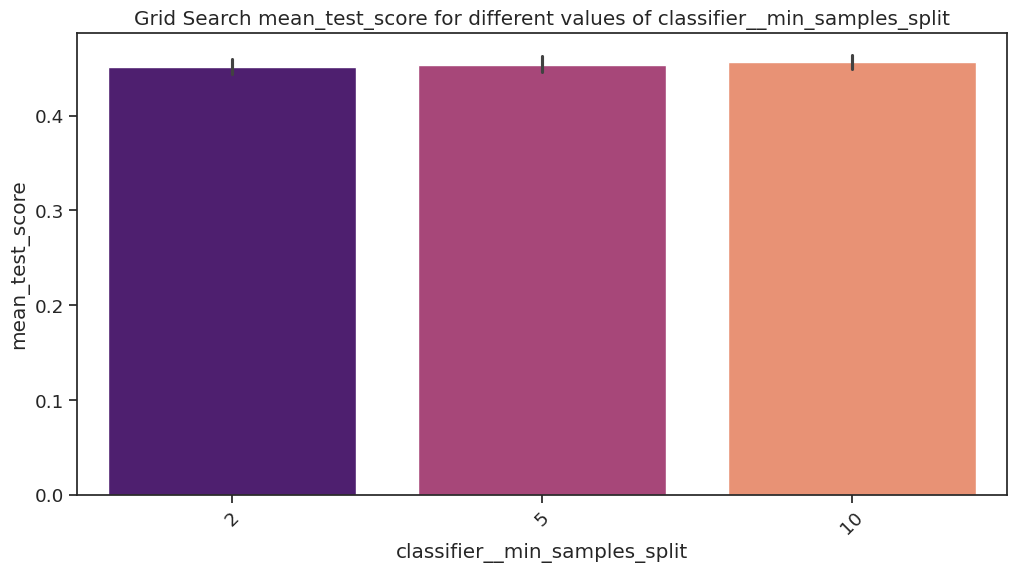

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the results from GridSearchCV
results = grid_rf_rus.cv_results_

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Function to plot bar charts of grid search results
def plot_grid_search_results(results_df, param, score='mean_test_score'):
    plt.figure(figsize=(12, 6))
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("ticks")

    # Extract the values of the specified parameter
    param_values = results_df[f'param_{param}'].astype(str)

    # Plot the results
    sns.barplot(x=param_values, y=results_df[score], palette='magma')

    plt.title(f'Grid Search {score} for different values of {param}')
    plt.xlabel(param)
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Example usage for Random Forest parameters
plot_grid_search_results(results_df, 'classifier__n_estimators', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__max_depth', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__min_samples_split', score='mean_test_score')


In [36]:
# Load the saved parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Print the updated parameters to verify
for category, models in top_model_params.items():
    print(f"Category: {category}")
    for model_name, params in models.items():
        print(f"  Model: {model_name}")
        print(f"    Best Params: {params['best_params']}")
        if 'best_threshold' in params:
            print(f"    Best Threshold: {params['best_threshold']}")
        else:
            print("    Best Threshold: Not defined")

Category: Class 1 Recall
  Model: Logistic Regression (ADASYN)
    Best Params: {'C': 6.7, 'solver': 'liblinear'}
    Best Threshold: Not defined
  Model: Logistic Regression (SMOTE)
    Best Params: {'C': 10.0, 'solver': 'liblinear'}
    Best Threshold: Not defined
  Model: LGBM (SMOTE)
    Best Params: {'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 31}
    Best Threshold: Not defined
Category: Class 1 Precision
  Model: Logistic Regression (baseline)
    Best Params: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
    Best Threshold: Not defined
  Model: LGBM (baseline)
    Best Params: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 70}
    Best Threshold: Not defined
  Model: Random Forest (class_weight_balanced)
    Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
    Best Threshold: Not defined
  Model: Random Forest (RandomUnderSampler)
    Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
    Best

In [38]:
# move Random Forest (RandomUnderSampler) model and params
# from Category: Class 1 Precision to Category: Class 0 Precision

import json

# Load the saved parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Remove the model from "Class 1 Precision" and add to "Class 0 Precision"
model_to_move = "Random Forest (RandomUnderSampler)"
if model_to_move in top_model_params["Class 1 Precision"]:
    params_to_move = top_model_params["Class 1 Precision"].pop(model_to_move)
    if "Class 0 Precision" not in top_model_params:
        top_model_params["Class 0 Precision"] = {}
    top_model_params["Class 0 Precision"][model_to_move] = params_to_move

# Save the updated top model parameters to the JSON file
with open('/content/top_model_params.json', 'w') as f:
    json.dump(top_model_params, f, indent=4)

# Loop through the parameters and print them
for category, models in top_model_params.items():
    print(f"Category: {category}")
    for model_name, params in models.items():
        print(f"  Model: {model_name}")
        print(f"    Best Params: {params['best_params']}")
        print(f"    Best Threshold: {params.get('best_threshold', 'Not defined')}")


Category: Class 1 Recall
  Model: Logistic Regression (ADASYN)
    Best Params: {'C': 6.7, 'solver': 'liblinear'}
    Best Threshold: Not defined
  Model: Logistic Regression (SMOTE)
    Best Params: {'C': 10.0, 'solver': 'liblinear'}
    Best Threshold: Not defined
  Model: LGBM (SMOTE)
    Best Params: {'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 31}
    Best Threshold: Not defined
Category: Class 1 Precision
  Model: Logistic Regression (baseline)
    Best Params: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
    Best Threshold: Not defined
  Model: LGBM (baseline)
    Best Params: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 70}
    Best Threshold: Not defined
  Model: Random Forest (class_weight_balanced)
    Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
    Best Threshold: Not defined
Category: Class 0 Recall
  Model: Logistic Regression (baseline)
    Best Params: {'C': 0.01, 'solver': 'liblinear'}
    Best Thresho

In [40]:
# Add optimal thresholds for class 1 recall

# Load the saved parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Update thresholds for Class 1 Recall models
class_1_recall_models = [
    "Logistic Regression (ADASYN)",
    "Logistic Regression (SMOTE)",
    "LGBM (SMOTE)"
]
thresholds = [0.2, 0.2, 0.1]

for model_name, threshold in zip(class_1_recall_models, thresholds):
    if model_name in top_model_params["Class 1 Recall"]:
        top_model_params["Class 1 Recall"][model_name]["best_threshold"] = threshold

# Save the updated top model parameters to the JSON file
with open('/content/top_model_params.json', 'w') as f:
    json.dump(top_model_params, f, indent=4)

# Loop through the parameters and print them
for category, models in top_model_params.items():
    print(f"Category: {category}")
    for model_name, params in models.items():
        print(f"  Model: {model_name}")
        print(f"    Best Params: {params['best_params']}")
        print(f"    Best Threshold: {params.get('best_threshold', 'Not defined')}")

Category: Class 1 Recall
  Model: Logistic Regression (ADASYN)
    Best Params: {'C': 6.7, 'solver': 'liblinear'}
    Best Threshold: 0.2
  Model: Logistic Regression (SMOTE)
    Best Params: {'C': 10.0, 'solver': 'liblinear'}
    Best Threshold: 0.2
  Model: LGBM (SMOTE)
    Best Params: {'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 31}
    Best Threshold: 0.1
Category: Class 1 Precision
  Model: Logistic Regression (baseline)
    Best Params: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
    Best Threshold: Not defined
  Model: LGBM (baseline)
    Best Params: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 70}
    Best Threshold: Not defined
  Model: Random Forest (class_weight_balanced)
    Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
    Best Threshold: Not defined
Category: Class 0 Recall
  Model: Logistic Regression (baseline)
    Best Params: {'C': 0.01, 'solver': 'liblinear'}
    Best Threshold: 0.1
  Model: LGBM (b

### Threshold Tuning - Class 0 Precision

[LightGBM] [Info] Number of positive: 5309, number of negative: 5309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3260
[LightGBM] [Info] Number of data points in the train set: 10618, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


<ipython-input-47-fe2df0abb24b>:23: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold for LGBM (RandomUnderSampler): 0.9010228304730621
Precision: 0.0, Recall: 0.0, F1: nan
Classification Report for LGBM (RandomUnderSampler) at best threshold:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000



<ipython-input-47-fe2df0abb24b>:32: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


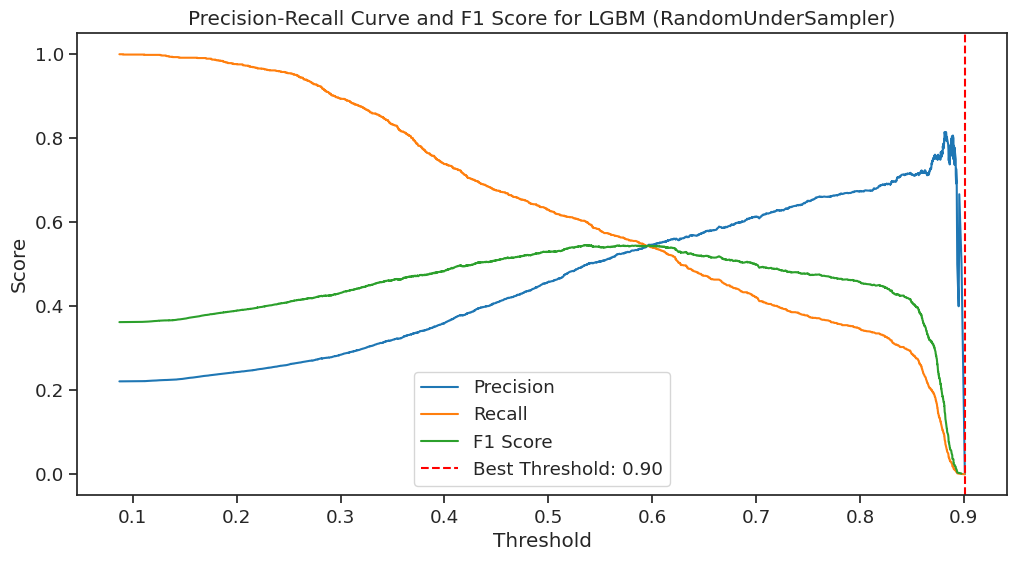

Best threshold for HistGradientBoosting (RandomUnderSampler): 0.5261519370959922
Precision: 0.49300254452926207, Recall: 0.5840241145440844, F1: 0.5346671265953776
Classification Report for HistGradientBoosting (RandomUnderSampler) at best threshold:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      4673
           1       0.49      0.58      0.53      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.71      0.69      6000
weighted avg       0.79      0.78      0.78      6000



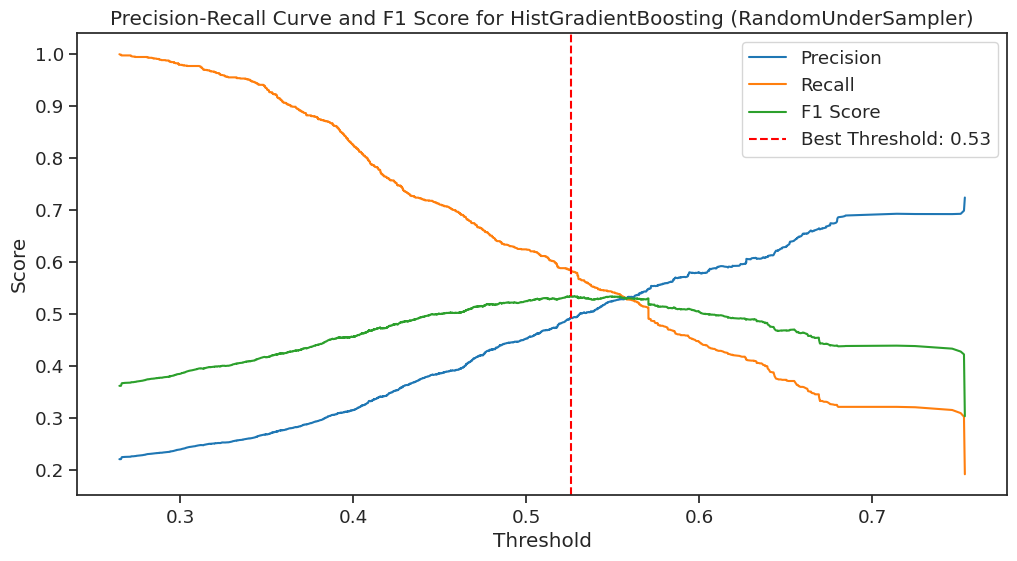

Best threshold for Random Forest (RandomUnderSampler): 0.5355444586908406
Precision: 0.5109054857898215, Recall: 0.5825169555388093, F1: 0.5443661971830985
Classification Report for Random Forest (RandomUnderSampler) at best threshold:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4673
           1       0.51      0.58      0.54      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.80      0.78      0.79      6000



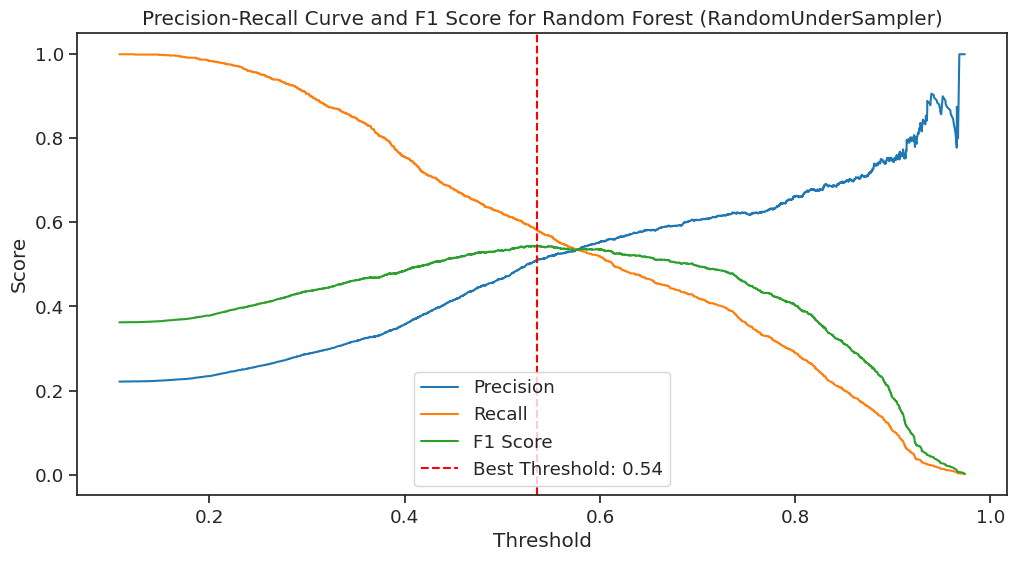

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, classification_report
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import json

# Function to evaluate model at different thresholds
def evaluate_thresholds(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]

    return thresholds, precision, recall, f1_scores, best_threshold, precision[best_threshold_index], recall[best_threshold_index], f1_scores[best_threshold_index]

# Function to plot precision-recall-threshold curve
def plot_precision_recall_thresholds(y_test, y_proba, model_name, best_threshold):
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)

    plt.figure(figsize=(12, 6))
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("ticks")

    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')

    plt.title(f'Precision-Recall Curve and F1 Score for {model_name}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

# Function to train model, evaluate thresholds, and print results
def threshold_tuning(model, model_name, X_train, X_test, y_train, y_test, params):
    # Update only the classifier parameters
    model.set_params(**{f'classifier__{key}': value for key, value in params.items()})
    model.fit(X_train, y_train)

    thresholds, precision, recall, f1_scores, best_threshold, best_precision, best_recall, best_f1 = evaluate_thresholds(model, X_test, y_test)
    print(f"Best threshold for {model_name}: {best_threshold}")
    print(f"Precision: {best_precision}, Recall: {best_recall}, F1: {best_f1}")

    y_pred = (model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {model_name} at best threshold:\n{report}")

    plot_precision_recall_thresholds(y_test, model.predict_proba(X_test)[:, 1], model_name, best_threshold)

    return best_threshold, best_precision, best_recall, best_f1

# Load the top model parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Assuming preprocessor is defined and you have your data split into X_train, X_test, y_train, y_test

# LGBM with RandomUnderSampler
pipeline_lgbm_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler()),
    ('classifier', LGBMClassifier(random_state=42))
])
best_params_lgbm_rus = top_model_params["Class 0 Precision"]["LGBM (RandomUnderSampler)"]["best_params"]
best_threshold_lgbm_rus, best_precision_lgbm_rus, best_recall_lgbm_rus, best_f1_lgbm_rus = threshold_tuning(pipeline_lgbm_rus, 'LGBM (RandomUnderSampler)', X_train, X_test, y_train, y_test, best_params_lgbm_rus)

# HistGradientBoosting with RandomUnderSampler
pipeline_hist_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler()),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])
best_params_hist_rus = top_model_params["Class 0 Precision"]["HistGradientBoosting (RandomUnderSampler)"]["best_params"]
best_threshold_hist_rus, best_precision_hist_rus, best_recall_hist_rus, best_f1_hist_rus = threshold_tuning(pipeline_hist_rus, 'HistGradientBoosting (RandomUnderSampler)', X_train, X_test, y_train, y_test, best_params_hist_rus)

# Random Forest with RandomUnderSampler
pipeline_rf_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler()),
    ('classifier', RandomForestClassifier(random_state=42))
])
best_params_rf_rus = top_model_params["Class 0 Precision"]["Random Forest (RandomUnderSampler)"]["best_params"]
best_threshold_rf_rus, best_precision_rf_rus, best_recall_rf_rus, best_f1_rf_rus = threshold_tuning(pipeline_rf_rus, 'Random Forest (RandomUnderSampler)', X_train, X_test, y_train, y_test, best_params_rf_rus)


In [48]:
import json

# Load the saved parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Set thresholds for "Class 0 Precision" models
top_model_params["Class 0 Precision"]["LGBM (RandomUnderSampler)"]["best_threshold"] = 0.85
top_model_params["Class 0 Precision"]["HistGradientBoosting (RandomUnderSampler)"]["best_threshold"] = 0.7
top_model_params["Class 0 Precision"]["Random Forest (RandomUnderSampler)"]["best_threshold"] = 0.9

# Save the updated top model parameters to the JSON file
with open('/content/top_model_params.json', 'w') as f:
    json.dump(top_model_params, f, indent=4)

# Loop through the parameters and print them
for category, models in top_model_params.items():
    print(f"Category: {category}")
    for model_name, params in models.items():
        print(f"  Model: {model_name}")
        print(f"    Best Params: {params['best_params']}")
        if 'best_threshold' in params:
            print(f"    Best Threshold: {params['best_threshold']}")
        else:
            print("    Best Threshold: Not defined")


Category: Class 1 Recall
  Model: Logistic Regression (ADASYN)
    Best Params: {'C': 6.7, 'solver': 'liblinear'}
    Best Threshold: 0.2
  Model: Logistic Regression (SMOTE)
    Best Params: {'C': 10.0, 'solver': 'liblinear'}
    Best Threshold: 0.2
  Model: LGBM (SMOTE)
    Best Params: {'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 31}
    Best Threshold: 0.1
Category: Class 1 Precision
  Model: Logistic Regression (baseline)
    Best Params: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
    Best Threshold: Not defined
  Model: LGBM (baseline)
    Best Params: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 70}
    Best Threshold: Not defined
  Model: Random Forest (class_weight_balanced)
    Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
    Best Threshold: Not defined
Category: Class 0 Recall
  Model: Logistic Regression (baseline)
    Best Params: {'C': 0.01, 'solver': 'liblinear'}
    Best Threshold: 0.1
  Model: LGBM (b

### Clean and Format Optimal Params File

In [50]:
import json

optimal_model_params = {
    "Class 1 Recall": {
        "Logistic Regression (ADASYN)": {
            "best_params": {
                "C": 6.7,
                "solver": "liblinear"
            },
            "best_threshold": 0.2
        },
        "Logistic Regression (SMOTE)": {
            "best_params": {
                "C": 10.0,
                "solver": "liblinear"
            },
            "best_threshold": 0.2
        },
        "LGBM (SMOTE)": {
            "best_params": {
                "learning_rate": 0.2,
                "n_estimators": 300,
                "num_leaves": 31
            },
            "best_threshold": 0.1
        }
    },
    "Class 1 Precision": {
        "Logistic Regression (baseline)": {
            "best_params": {
                "C": 10.0,
                "penalty": "l2",
                "solver": "liblinear"
            },
            "best_threshold": None
        },
        "LGBM (baseline)": {
            "best_params": {
                "learning_rate": 0.01,
                "n_estimators": 100,
                "num_leaves": 70
            },
            "best_threshold": None
        },
        "Random Forest (class_weight_balanced)": {
            "best_params": {
                "max_depth": None,
                "min_samples_split": 2,
                "n_estimators": 100
            },
            "best_threshold": None
        }
    },
    "Class 0 Recall": {
        "Logistic Regression (baseline)": {
            "best_params": {
                "C": 0.01,
                "solver": "liblinear"
            },
            "best_threshold": 0.1
        },
        "LGBM (baseline)": {
            "best_params": {
                "learning_rate": 0.05,
                "n_estimators": 100,
                "num_leaves": 31
            },
            "best_threshold": 0.1
        },
        "Random Forest (class_weight_balanced)": {
            "best_params": {
                "max_depth": 10,
                "min_samples_leaf": 10,
                "min_samples_split": 2,
                "n_estimators": 100
            },
            "best_threshold": 0.1
        }
    },
    "Class 0 Precision": {
        "LGBM (RandomUnderSampler)": {
            "best_params": {
                "learning_rate": 0.01,
                "n_estimators": 300,
                "num_leaves": 31
            },
            "best_threshold": 0.85
        },
        "HistGradientBoosting (RandomUnderSampler)": {
            "best_params": {
                "learning_rate": 0.01,
                "max_iter": 100,
                "max_leaf_nodes": 31
            },
            "best_threshold": 0.7
        },
        "Random Forest (RandomUnderSampler)": {
            "best_params": {
                "max_depth": 10,
                "min_samples_split": 10,
                "n_estimators": 200
            },
            "best_threshold": 0.9
        }
    }
}

# Save the updated top model parameters to the JSON file
with open('/content/optimal_model_params.json', 'w') as f:
    json.dump(optimal_model_params, f, indent=4)


### Threshold Tuning - Class 1 Precision

Best threshold for Logistic Regression (baseline): 0.2812629752179165
Precision: 0.5210355987055016, Recall: 0.4853051996985682, F1: 0.5025360905189232
Classification Report for Logistic Regression (baseline) at best threshold:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4673
           1       0.52      0.49      0.50      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.68      0.68      6000
weighted avg       0.78      0.79      0.78      6000



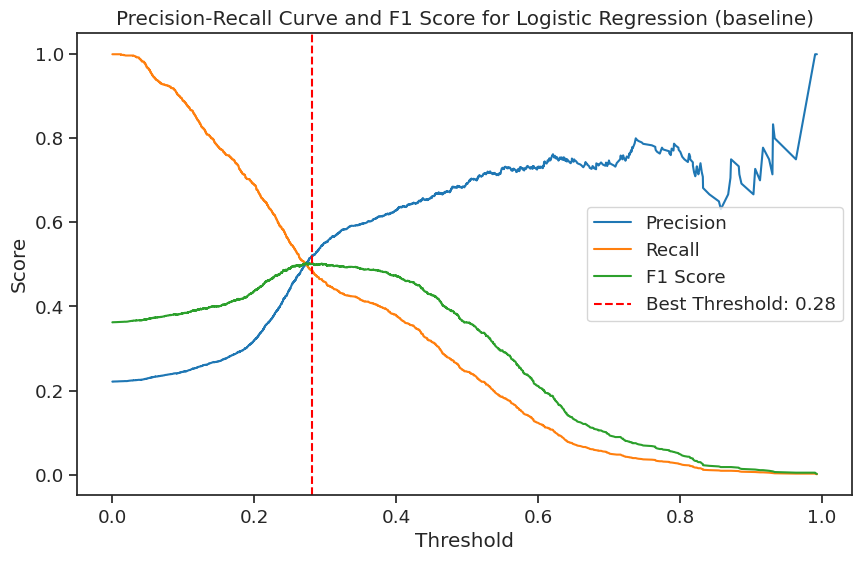

[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639
Best threshold for LGBM (baseline): 0.25417773076683403
Precision: 0.5197779319916724, Recall: 0.5644310474755087, F1: 0.5411849710982659
Classification Report for LGBM (baseline) at best threshold:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4673
           1       0.52      0.56      0.54      1327

    accuracy                           0.79      6000
   macro avg       0.70   

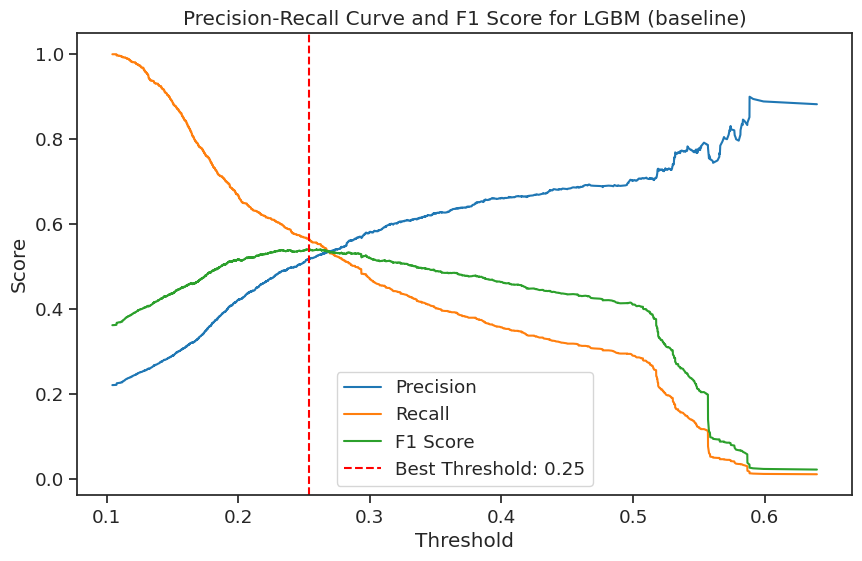

Best threshold for Random Forest (class_weight_balanced): 0.29875641235857675
Precision: 0.5154121863799284, Recall: 0.5418236623963828, F1: 0.5282880235121235
Classification Report for Random Forest (class_weight_balanced) at best threshold:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4673
           1       0.52      0.54      0.53      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.70      0.69      6000
weighted avg       0.79      0.79      0.79      6000



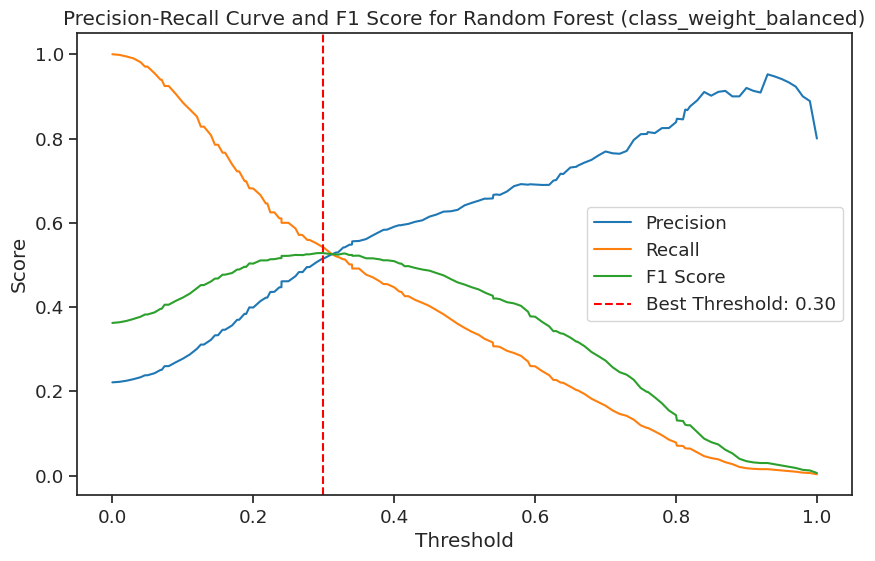

In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Function to evaluate model at different thresholds
def evaluate_thresholds(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]

    return best_threshold, precision[best_threshold_index], recall[best_threshold_index], f1_scores[best_threshold_index]

# Function to train model, evaluate thresholds, and save results
def threshold_tuning(model, model_name, X_train, X_test, y_train, y_test, params):
    model.set_params(**{f'classifier__{key}': value for key, value in params.items()})
    model.fit(X_train, y_train)

    best_threshold, best_precision, best_recall, best_f1 = evaluate_thresholds(model, X_test, y_test)
    print(f"Best threshold for {model_name}: {best_threshold}")
    print(f"Precision: {best_precision}, Recall: {best_recall}, F1: {best_f1}")

    y_pred = (model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {model_name} at best threshold:\n{report}")

    plot_precision_recall_thresholds(y_test, model.predict_proba(X_test)[:, 1], model_name)

    return best_threshold, best_precision, best_recall, best_f1

# Function to plot precision-recall-threshold curve
def plot_precision_recall_thresholds(y_test, y_proba, model_name):
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.plot(thresholds, f1_scores[:-1], label='F1 Score')

    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]

    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision-Recall Curve and F1 Score for {model_name}')
    plt.legend()
    plt.show()

# Load the top model parameters
with open('/content/optimal_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Logistic Regression (baseline)
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])
best_params_lr = top_model_params["Class 1 Precision"]["Logistic Regression (baseline)"]["best_params"]
best_threshold_lr, best_precision_lr, best_recall_lr, best_f1_lr = threshold_tuning(pipeline_lr, 'Logistic Regression (baseline)', X_train, X_test, y_train, y_test, best_params_lr)

# LGBM (baseline)
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42))
])
best_params_lgbm = top_model_params["Class 1 Precision"]["LGBM (baseline)"]["best_params"]
best_threshold_lgbm, best_precision_lgbm, best_recall_lgbm, best_f1_lgbm = threshold_tuning(pipeline_lgbm, 'LGBM (baseline)', X_train, X_test, y_train, y_test, best_params_lgbm)

# Random Forest (class_weight_balanced)
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
best_params_rf = top_model_params["Class 1 Precision"]["Random Forest (class_weight_balanced)"]["best_params"]
best_threshold_rf, best_precision_rf, best_recall_rf, best_f1_rf = threshold_tuning(pipeline_rf, 'Random Forest (class_weight_balanced)', X_train, X_test, y_train, y_test, best_params_rf)


In [53]:
import json

# Load the optimal model parameters
with open('/content/optimal_model_params.json', 'r') as f:
    optimal_model_params = json.load(f)

# Define the best thresholds
best_thresholds_class_1_precision = [0.5, 0.5, 0.5]

# Update the JSON structure with the new thresholds
optimal_model_params["Class 1 Precision"]["Logistic Regression (baseline)"]["best_threshold"] = best_thresholds_class_1_precision[0]
optimal_model_params["Class 1 Precision"]["LGBM (baseline)"]["best_threshold"] = best_thresholds_class_1_precision[1]
optimal_model_params["Class 1 Precision"]["Random Forest (class_weight_balanced)"]["best_threshold"] = best_thresholds_class_1_precision[2]

# Save the updated JSON structure
with open('/content/optimal_model_params.json', 'w') as f:
    json.dump(optimal_model_params, f, indent=4)

# Print the updated JSON structure
print(json.dumps(optimal_model_params, indent=4))


{
    "Class 1 Recall": {
        "Logistic Regression (ADASYN)": {
            "best_params": {
                "C": 6.7,
                "solver": "liblinear"
            },
            "best_threshold": 0.2
        },
        "Logistic Regression (SMOTE)": {
            "best_params": {
                "C": 10.0,
                "solver": "liblinear"
            },
            "best_threshold": 0.2
        },
        "LGBM (SMOTE)": {
            "best_params": {
                "learning_rate": 0.2,
                "n_estimators": 300,
                "num_leaves": 31
            },
            "best_threshold": 0.1
        }
    },
    "Class 1 Precision": {
        "Logistic Regression (baseline)": {
            "best_params": {
                "C": 10.0,
                "penalty": "l2",
                "solver": "liblinear"
            },
            "best_threshold": 0.5
        },
        "LGBM (baseline)": {
            "best_params": {
                "learning_rate": 0.01,


### Proper JSON file Set Up

Starting from scratch, the best way to set up the parameter file is to ensure it's structured, maintainable, and easy to access and update. Here’s a recommended approach:

### 1. Structure the JSON File
The JSON file should be hierarchical, with clear categories, models, and parameter keys. For better maintainability, you can include fields for both `best_params` and `best_threshold`.

### 2. Define the JSON Schema
The schema should look like this:
- Category (e.g., Class 1 Recall, Class 1 Precision, Class 0 Recall, Class 0 Precision)
  - Model
    - best_params
    - best_threshold

### 3. Example JSON Structure
Here is an example structure:

```json
{
    "Class 1 Recall": {
        "Logistic Regression (ADASYN)": {
            "best_params": {
                "C": 6.7,
                "solver": "liblinear"
            },
            "best_threshold": 0.2
        },
        "Logistic Regression (SMOTE)": {
            "best_params": {
                "C": 10.0,
                "solver": "liblinear"
            },
            "best_threshold": 0.2
        },
        "LGBM (SMOTE)": {
            "best_params": {
                "learning_rate": 0.2,
                "n_estimators": 300,
                "num_leaves": 31
            },
            "best_threshold": 0.1
        }
    },
    "Class 1 Precision": {
        "Logistic Regression (baseline)": {
            "best_params": {
                "C": 10.0,
                "penalty": "l2",
                "solver": "liblinear"
            },
            "best_threshold": 0.5
        },
        "LGBM (baseline)": {
            "best_params": {
                "learning_rate": 0.01,
                "n_estimators": 100,
                "num_leaves": 70
            },
            "best_threshold": 0.5
        },
        "Random Forest (class_weight_balanced)": {
            "best_params": {
                "max_depth": null,
                "min_samples_split": 2,
                "n_estimators": 100
            },
            "best_threshold": 0.5
        }
    },
    "Class 0 Recall": {
        "Logistic Regression (baseline)": {
            "best_params": {
                "C": 0.01,
                "solver": "liblinear"
            },
            "best_threshold": 0.1
        },
        "LGBM (baseline)": {
            "best_params": {
                "learning_rate": 0.05,
                "n_estimators": 100,
                "num_leaves": 31
            },
            "best_threshold": 0.1
        },
        "Random Forest (class_weight_balanced)": {
            "best_params": {
                "max_depth": 10,
                "min_samples_leaf": 10,
                "min_samples_split": 2,
                "n_estimators": 100
            },
            "best_threshold": 0.1
        }
    },
    "Class 0 Precision": {
        "LGBM (RandomUnderSampler)": {
            "best_params": {
                "learning_rate": 0.01,
                "n_estimators": 300,
                "num_leaves": 31
            },
            "best_threshold": 0.85
        },
        "HistGradientBoosting (RandomUnderSampler)": {
            "best_params": {
                "learning_rate": 0.01,
                "max_iter": 100,
                "max_leaf_nodes": 31
            },
            "best_threshold": 0.7
        },
        "Random Forest (RandomUnderSampler)": {
            "best_params": {
                "max_depth": 10,
                "min_samples_split": 10,
                "n_estimators": 200
            },
            "best_threshold": 0.9
        }
    }
}
```

### 4. Accessing and Updating the JSON File
Use a consistent method to access and update the parameters, ensuring the structure is maintained.

#### Load Parameters
```python
import json

def load_params(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

params = load_params('/content/optimal_model_params.json')
```

#### Update Parameters
```python
def update_params(file_path, category, model_name, best_params, best_threshold=None):
    with open(file_path, 'r') as f:
        params = json.load(f)

    if category not in params:
        params[category] = {}
    if model_name not in params[category]:
        params[category][model_name] = {}
    
    params[category][model_name]['best_params'] = best_params
    if best_threshold is not None:
        params[category][model_name]['best_threshold'] = best_threshold

    with open(file_path, 'w') as f:
        json.dump(params, f, indent=4)

# Example usage
update_params('/content/optimal_model_params.json', 'Class 1 Precision', 'Logistic Regression (baseline)', {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}, 0.5)
```

#### Print Parameters
```python
def print_params(file_path):
    with open(file_path, 'r') as f:
        params = json.load(f)
    
    for category, models in params.items():
        print(f"Category: {category}")
        for model_name, model_params in models.items():
            print(f"  Model: {model_name}")
            print(f"    Best Params: {model_params['best_params']}")
            if 'best_threshold' in model_params:
                print(f"    Best Threshold: {model_params['best_threshold']}")

print_params('/content/optimal_model_params.json')
```

### 5. Handling Updates and Access
Ensure functions to update and access the JSON file check for the existence of keys and handle missing data gracefully.

By following this structured approach, you can maintain and update the parameter file with fewer errors and better manageability.

### Write Data Utils Script

In [10]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

def plot_mean_class_metrics(df):
    """
    Function to calculate and plot the mean recall and precision metrics for class 0 and class 1.
    """
    # Calculate the mean of recall and precision for both classes
    metrics_df = pd.DataFrame({
        'Metric': ['Recall_0', 'Precision_0', 'Recall_1', 'Precision_1'],
        'Mean Value': [
            df['Recall_0'].mean(),
            df['Precision_0'].mean(),
            df['Recall_1'].mean(),
            df['Precision_1'].mean()
        ]
    })

    # Plot the mean of recall and precision for each class
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Mean Value', data=metrics_df, palette='mako')
    plt.title('Mean Recall and Precision for Class 0 and Class 1')
    plt.xlabel('Metric')
    plt.ylabel('Mean Value')
    for index, row in metrics_df.iterrows():
        plt.text(index, row['Mean Value'], f'{row["Mean Value"]:.2f}', ha='center', va='bottom')
    plt.show()

#--------   Evaluate and Capture Metrics   --------#

def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }

    logger.info(f"Completed evaluation for model: {model_name} ({experiment_name})")
    return metrics

def compile_metrics(metrics_list, experiment_name='experiment_name'):
    metrics_df = pd.DataFrame(metrics_list)
    csv_filename = f'{experiment_name}_metrics.csv'
    metrics_df.to_csv(csv_filename, index=False)
    logger.info(f"Metrics saved to {csv_filename}")
    return metrics_df


def clean_params(params):
    """
    Clean the model parameters by removing the 'classifier__' prefix.
    """
    return {key.replace('classifier__', ''): value for key, value in params.items()}

# --------   Get Top Performers   --------#

import pandas as pd
def get_top_performers(metrics_df, top_n=3):
    metrics = ['Recall_0', 'Precision_0', 'Recall_1', 'Precision_1']
    top_performers = []

    for metric in metrics:
        sorted_df = metrics_df[['Experiment', 'Model', metric]].sort_values(by=metric, ascending=False).head(top_n)
        sorted_df['Metric'] = metric
        sorted_df = sorted_df.rename(columns={metric: 'Value'})
        top_performers.append(sorted_df)

    # Concatenate all top performers into a single DataFrame
    top_performers_df = pd.concat(top_performers, ignore_index=True)

    # Save the results to a CSV file
    top_performers_df.to_csv('top_performing_models.csv', index=False)
    return top_performers_df

def select_and_sort_top_n(df, columns, n=3):
    """
    Selects the top n rows based on each specified column and returns a DataFrame with all columns.

    Args:
    df (pd.DataFrame): The input DataFrame.
    columns (list of str): The columns to sort by.
    n (int): The number of top rows to select for each column.

    Returns:
    pd.DataFrame: A DataFrame containing the top n rows for each specified column, without duplicates.
    """
    top_n_combined_df = pd.DataFrame()

    for column in columns:
        top_n = df.nlargest(n, column)
        top_n_combined_df = pd.concat([top_n_combined_df, top_n])

    # Drop duplicates and reset index
    top_n_combined_df = top_n_combined_df.drop_duplicates().reset_index(drop=True)

    return top_n_combined_df

'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
